# Different ways of fitting the splines

### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), fully attractive ("att") or have a turning point/switch ("sw"), which is defined by the "Swtype" key.
* "rep", The resulting spline is purely repulsive, meaning the curvature decreases at further interatomic distances, i.e. c_i > 0 for all i. 
* "att", The resulting spline is purely attractive, meaning the curvature increases at further interatomic distances, i.e. c_i < 0 for all i.
* "sw", The resulting spline is allowed to switch, such that at some point the curvature goes from being positive to being negative. 

In the last case, to search for the optimal switching point there are again three options, which can be set using the "search_mode":
* "full", a brute force implementation, which goes over all points (and all combinations of those specified for other pairs of elements) specified by the cut-off distance Rcut and the resolution "Resolution". This option scales very poorly with the number of elements.
* "range", uses the additional keywords "range_center" and "range_width", searching through all points between \[range_center - range_width/2, range_center + range_width/2\], depending on the resolution.
* "point", uses the additional keyword "search_points", which should be an array of interatomic distances to be probed. The nearest points defined by the resolution will then be probed.

In [1]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="LJ.db",include_forces=True)

    Fetching data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 451.66it/s]


In [2]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
        "do_unconstrained_fit" : "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                },
                "Na-Cl": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [3]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Generating two-body potentials from one-body information.
    Adding pair: Cl-Cl
    Adding pair: Na-Na
    Applying monotonous constraints for pair:  Na-Cl
    Applying monotonous constraints for pair:  Cl-Cl
    Applying monotonous constraints for pair:  Na-Na
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na
    Condition number is: 8.397261055739331e+22 ( 44 259005.9298566056 0.0)
    MSE of unconstrained problem is:  0.12504319291008434
    Final root mean square error in energy:  0.005680903826858683  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


/home/thism292/Documents/repos/CCS_fit/src/ccs_fit/fitting/spline_functions.py:321: RuntimeWarning: invalid value encountered in log
  beta = alpha * r0 + np.log(cc / alpha**2)
    Finding optimum switch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2662/2662 [00:24<00:00, 110.91it/s]

    The best switch is (1, 2, 1) with mse: 6.3155, corresponding to distances of [1.1  4.02 3.97] Å for element pairs ['Na-Cl', 'Cl-Cl', 'Na-Na'].
    Final root mean square error in energy:  0.005766813784176243  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


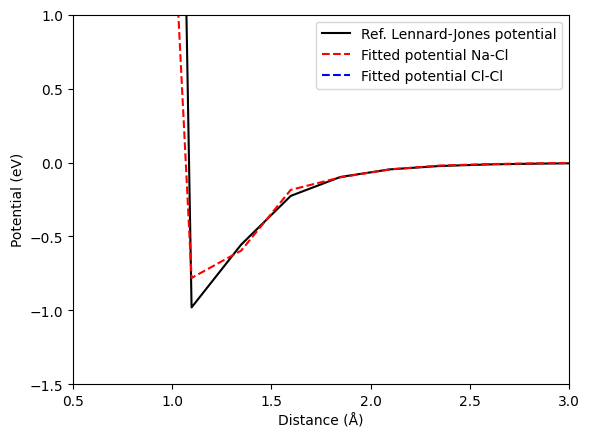

In [4]:
import matplotlib.pyplot as plt
import numpy as np

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

ClCl = CCS_params["Two_body"]["Cl-Cl"]["spl_a"]
NaCl = CCS_params["Two_body"]["Na-Cl"]["spl_a"]
NaNa = CCS_params["Two_body"]["Na-Na"]["spl_a"]

r=np.array(CCS_params["Two_body"]["Na-Cl"]["r"])
e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)

r_ClCl = np.array(CCS_params["Two_body"]["Cl-Cl"]["r"])

plt.xlim(0.5,3)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,NaCl,'--',color='red',label="Fitted potential Na-Cl")
plt.plot(r_ClCl, ClCl,'--',color='blue',label="Fitted potential Cl-Cl")
plt.legend()
plt.show()

In [5]:
input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                },
                "Na-Cl": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.1,
                        "range_width": 0.25 # Å
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [6]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Generating two-body potentials from one-body information.
    Adding pair: Cl-Cl
    Adding pair: Na-Na
    Applying monotonous constraints for pair:  Na-Cl
    Applying monotonous constraints for pair:  Cl-Cl
    Applying monotonous constraints for pair:  Na-Na
    Merging interval for pair Na-Cl. Number of knots reduced from 103 to 96. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na
    Range search turned on for element pair Na-Cl; 4 possible switch indices in range of 0.95-1.35 Å.
    Condition number is: 3.2271612825059456e+23 ( 118 84066.76020061527 0.0)


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 484/484 [00:10<00:00, 45.22it/s]

    The best switch is (5, 1, 1) with mse: 0.037438, corresponding to distances of [1.2  3.77 3.97] Å for element pairs ['Na-Cl', 'Cl-Cl', 'Na-Na'].
    Final root mean square error in energy:  0.0007584245430096805  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


In [7]:
input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
    },
    "Twobody": {
                "Cl-Cl": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [3.77]
                },
                "Na-Na": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [3.97]
                },
                "Na-Cl": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        # "search_points": [1.0, 1.15, 1.30, 1.50, 2.0], # Å
                        "range_center": 1.2,
                        "range_width": 0.2 # Å
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [8]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Applying monotonous constraints for pair:  Cl-Cl
    Applying monotonous constraints for pair:  Na-Na
    Applying monotonous constraints for pair:  Na-Cl
    Merging interval for pair Cl-Cl. Number of knots reduced from 237 to 228. 
    Merging interval for pair Na-Na. Number of knots reduced from 217 to 215. 
    Merging interval for pair Na-Cl. Number of knots reduced from 505 to 422. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na
    Switch points located at [3.79] Å to for element pair Cl-Cl based on point search.
    Switch points located at [3.97] Å to for element pair Na-Na based on point search.
    Range search turned on for element pair Na-Cl; 9 possible switch indices in range of 1.00-1.40 Å.
    Condition number is: 3.509528662114861e+24 ( 865 25994.838215453827 0.0)


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.65it/s]


    The best switch is (15, 13, 18) with mse: 3.7539e-05, corresponding to distances of [3.79 3.97 1.15] Å for element pairs ['Cl-Cl', 'Na-Na', 'Na-Cl'].
    Final root mean square error in energy:  0.0002481495498065288  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


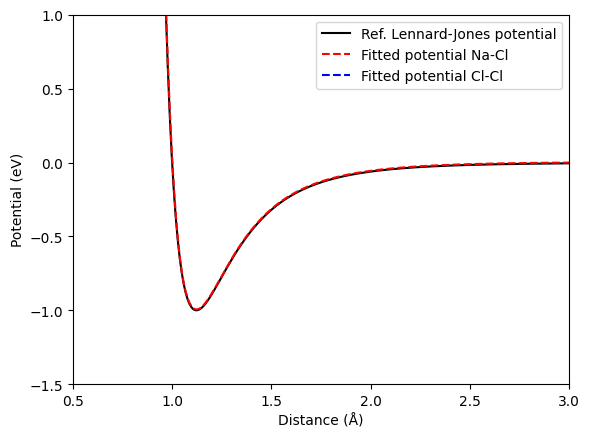

In [9]:
with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

ClCl = CCS_params["Two_body"]["Cl-Cl"]["spl_a"]
NaCl = CCS_params["Two_body"]["Na-Cl"]["spl_a"]
NaNa = CCS_params["Two_body"]["Na-Na"]["spl_a"]

r=np.array(CCS_params["Two_body"]["Na-Cl"]["r"])
e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)

r_ClCl = np.array(CCS_params["Two_body"]["Cl-Cl"]["r"])

plt.xlim(0.5,3)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,NaCl,'--',color='red',label="Fitted potential Na-Cl")
plt.plot(r_ClCl, ClCl,'--',color='blue',label="Fitted potential Cl-Cl")
plt.legend()
plt.show()

### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [10]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="LJ.db")

  0%|                                                                                                                                                                                                                                   | 0/167 [00:00<?, ?it/s]/home/thism292/anaconda3/envs/CCS_fit_search_mode/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 172.33it/s]


22


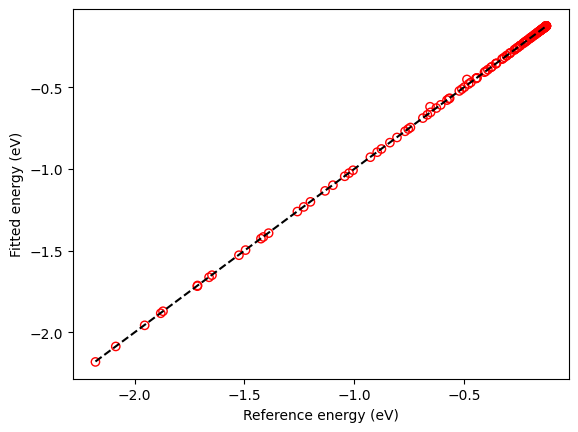

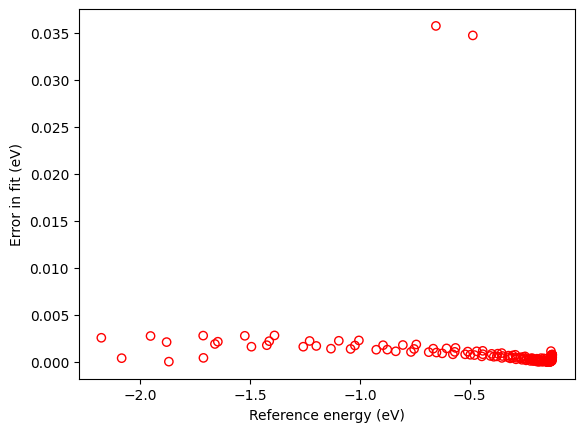

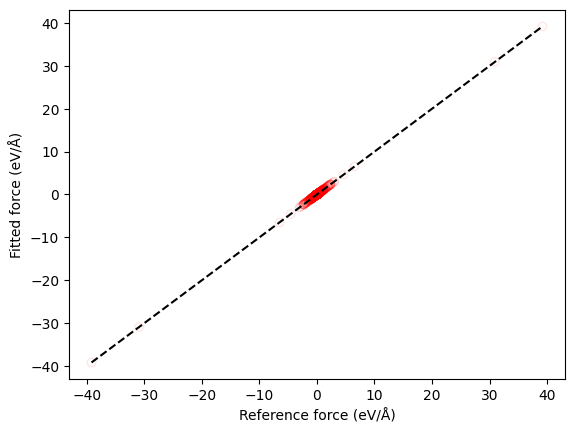

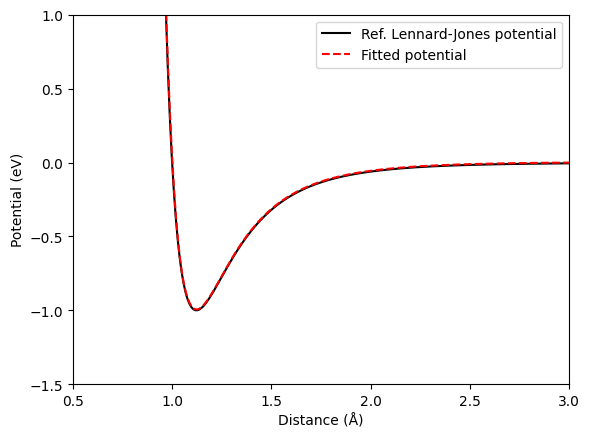

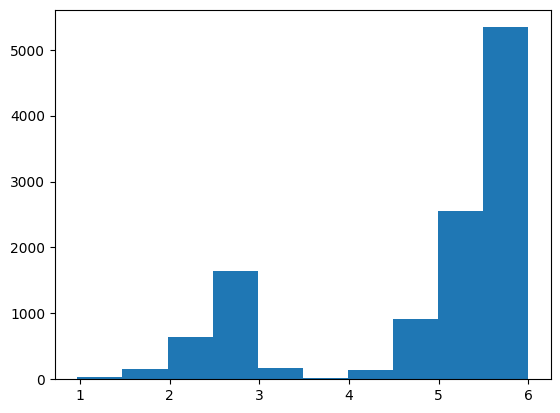

In [11]:
import matplotlib.pyplot as plt

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("UNC_params.json", "r") as f:
    unc_params = json.load(f)
    
with open("structures.json", "r") as f:
    training_set = json.load(f)

r=np.array(CCS_params["Two_body"]["Na-Cl"]["r"])
e=CCS_params["Two_body"]["Na-Cl"]["spl_a"]
unc=unc_params["Two_body"]["Na-Cl"]["spl_a"]

print(len(unc))

try:
    err=np.loadtxt("CCS_error.out")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Fitted energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

try:
    err_F=np.loadtxt("CCS_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
    plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
    plt.show()
except:
    pass

e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)
plt.xlim(0.5,3)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
# plt.plot(r,unc,'--',color='blue',label="Fitted potential w/o constraints")
plt.legend()
plt.show()

d=[]
for t in training_set["energies"]:
    d.extend(training_set["energies"][t]["Na-Cl"])

plt.hist(d)
plt.show()
